In [1]:
import matplotlib.pyplot as plt
import os, re, pickle
import scipy.io
from collections import defaultdict
import numpy as np

import pandas as pd
import shutil

def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def nested_dict(n):
    if n == 1:
        return defaultdict(lambda: np.ndarray(0))
    else:
        return defaultdict(lambda: nested_dict(n-1))

color_code = {
    "DET vs FullGradCAM":       "blue",
    "EXP_original vs ODAM":      "red",
    "EXP_cropped vs ODAM":      "orange",
}

linestyle = {
    0:'dotted',
    1:'dashed',
    2:'solid'
}

alpha = 0.3

In [2]:
# Images with empty saliency maps (detection failure) found in previous analysis
included_imgs = defaultdict(list)

included_imgs_path = {
    # "MSCOCO":"/mnt/h/OneDrive - The University Of Hong Kong/mscoco/xai_saliency_maps_yolov5s/yolov5s_mscoco_included.txt",
    "vehicle":"/mnt/h/OneDrive - The University Of Hong Kong/bdd/xai_saliency_maps_same_layer/yolov5s_vehicle_included.txt",
    "human":"/mnt/h/OneDrive - The University Of Hong Kong/bdd/xai_saliency_maps_same_layer/yolov5s_human_included.txt"
}

for category in included_imgs_path:
    file = open(included_imgs_path[category])
    included_imgs[category] = [line.strip() for line in file]

# Images with empty saliency maps (detection failure) found in previous analysis
excluded_imgs = defaultdict(list)

excluded_imgs_path = {
    "MSCOCO":"/mnt/h/OneDrive - The University Of Hong Kong/mscoco/xai_saliency_maps_yolov5s/yolov5s_mscoco_excluded.txt",
    "vehicle":"/mnt/h/OneDrive - The University Of Hong Kong/bdd/xai_saliency_maps_same_layer/yolov5s_vehicle_excluded.txt",
    "human":"/mnt/h/OneDrive - The University Of Hong Kong/bdd/xai_saliency_maps_same_layer/yolov5s_human_excluded.txt"
}

for category in excluded_imgs_path:
    file = open(excluded_imgs_path[category])
    excluded_imgs[category] = [line.strip() for line in file]

In [3]:
head_info_path = {
    "MSCOCO":'/mnt/h/jinhan/results/mscoco/xai_saliency_maps_yolov5s/fullgradcamraw_by_head/yolov5s_COCO_pred_info_by_head.csv',
    "vehicle":'/mnt/h/jinhan/results/bdd/xai_saliency_maps_yolov5s/vehicle_fullgradcamraw_by_head/yolov5s_vehicle_pred_info_by_head.csv',
    "human":'/mnt/h/jinhan/results/bdd/xai_saliency_maps_yolov5s/human_fullgradcamraw_by_head/yolov5s_human_pred_info_by_head.csv',
}

head_info = {}

for category, path in head_info_path.items():
    head_info[category] = pd.read_csv(path)

# Filter Human Fixations by Targets

In [5]:
all_fixations_path = {
    "MSCOCO":{
        'DET':"/mnt/h/OneDrive - The University Of Hong Kong/mscoco/fixation/split_by_id/padding_subtracted/DET_excluded",
        'EXP':"/mnt/h/OneDrive - The University Of Hong Kong/mscoco/fixation/split_by_id/padding_subtracted/EXP_excluded_cleaned",
        'PV':"/mnt/h/OneDrive - The University Of Hong Kong/mscoco/fixation/split_by_id/padding_subtracted/PV",
    },
    "vehicle":{
        'DET':"/mnt/h/OneDrive - The University Of Hong Kong/bdd/fixation/split_by_id/Veh_Yolo_IdTask_Fixation",
        'EXP':"/mnt/h/OneDrive - The University Of Hong Kong/bdd/fixation/split_by_id/Veh_Yolo_ExpTask_Fixation",
    },
    "human":{
        'DET':"/mnt/h/OneDrive - The University Of Hong Kong/bdd/fixation/split_by_id/Hum_Yolo_IdTask_Fixation",
        'EXP':"/mnt/h/OneDrive - The University Of Hong Kong/bdd/fixation/split_by_id/Hum_Yolo_ExpTask_Fixation",
    },
}

EXP_attentions_path_orig = {
    "MSCOCO":'/mnt/h/OneDrive - The University Of Hong Kong/mscoco/attention_maps/231222_EXP_excluded_cleaned_resized/attention_maps',
    "vehicle":'/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/240107 Veh EXP/all_participants',
    "human":'/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/240107 Hum EXP/all_participants',
}
EXP_attentions_path_nocrop = {
    "MSCOCO":'/mnt/h/OneDrive - The University Of Hong Kong/mscoco/attention_maps/231222_EXP_excluded_cleaned_resized/by_head_nocrop/',
    "vehicle":'/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/240107 Veh EXP/by_head_nocrop/',
    "human":'/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/240107 Hum EXP/by_head_nocrop/',
}

In [7]:
# Create target directorys for saving fixations splitted by target scales if not exist
for category in all_fixations_path:
    for type, path in all_fixations_path[category].items():
        new_path = f"{path}/instances/"
        if not os.path.exists(new_path):
            os.makedirs(new_path)

        for head in range(3):
            new_path = f"{path}/head{head}/"
            if not os.path.exists(new_path):
                os.makedirs(new_path)

            if type == 'EXP':
                new_path = f"{EXP_attentions_path_nocrop[category]}/head{head}" # just assign the intact EXP to the corresponding head without cropping
                if not os.path.exists(new_path):
                    os.makedirs(new_path)

In [6]:
def filter_fixations(df, boxes, output_file_path):
    
    # Initialize an empty mask
    mask = pd.Series([False] * len(df))
    
    # Loop through each box and update the mask
    for (x1, y1, x2, y2) in boxes:
        # Create a temporary mask for the current box
        temp_mask = (df['CURRENT_FIX_X'] >= x1) & (df['CURRENT_FIX_X'] <= x2) & \
                    (df['CURRENT_FIX_Y'] >= y1) & (df['CURRENT_FIX_Y'] <= y2)
        # Combine the temporary mask with the main mask using OR
        mask = mask | temp_mask
    
    # Filtered dataframe
    filtered_df = df[mask]

    if len(filtered_df) == 0:
        print(output_file_path)
        return
    
    # Save the filtered dataframe to a new Excel file
    filtered_df.to_excel(output_file_path, index=False)

### (at the same scale)

In [39]:
# For each image, find all targets at the same scale
# for category in all_fixations_path:
for category in ['vehicle','human']:
    head_df_grouped_by_img = head_info[category].groupby('img')
    for img, group in head_df_grouped_by_img:

        img = str(img).replace('.png','').replace('.jpg','')

        if str(img) in excluded_imgs[category]: 
            continue

        for head in range(3):

            # Find all targets from this head
            targets_from_head = group[group['head_num']==head]
            if len(targets_from_head) == 0: continue
            boxes = targets_from_head[['x1','y1','x2','y2']].to_numpy()

            # DET
            path = all_fixations_path[category]['DET']
            fixations = pd.read_excel(os.path.join(path,f'{img}.xlsx'))
            filter_fixations(fixations, boxes, os.path.join(f"{path}/head{head}",f"{img}.xlsx"))

            # PV
            if category == 'MSCOCO':
                path = all_fixations_path[category]['PV']
                fixations = pd.read_excel(os.path.join(path,f'{img}.xlsx'))
                filter_fixations(fixations, boxes, os.path.join(f"{path}/head{head}",f"{img}.xlsx"))

            # EXP
            # Find the EXP target
            exp_target = targets_from_head[targets_from_head['is_exp_target']]
            if len(exp_target) == 1: # only generate human attention maps for images where AI find the correct target

                # Group the original attention maps to the correct head folder
                exp_attention_orig_filename = f"{img}_GSmo_{21 if category=='MSCOCO' else 30}.mat"
                shutil.copyfile(os.path.join(EXP_attentions_path_orig[category],exp_attention_orig_filename),
                                 os.path.join(EXP_attentions_path_nocrop[category],f'head{head}',exp_attention_orig_filename))
                
                # Also filter the EXP attention within the BB
                path = all_fixations_path[category]['EXP']
                fixations = pd.read_excel(os.path.join(path,f'{img}.xlsx'))
                filter_fixations(fixations, 
                                 exp_target[['x1','y1','x2','y2']].to_numpy(), 
                                 os.path.join(f"{path}/head{head}",f"{img}.xlsx"))


... proceed to matlab to generate human attention maps

### Individual Targets

In [13]:
# For each image, find all targets at the same scale
# for category in all_fixations_path:
for category in ['vehicle','human']:

    head_df_grouped_by_img = head_info[category].groupby('img')
    for img, group in head_df_grouped_by_img:

        img = str(img).replace('.png','').replace('.jpg','')

        if str(img) not in included_imgs[category]: 
            continue

        # DET
        path = all_fixations_path[category]['DET']
        fixations = pd.read_excel(os.path.join(path,f'{img}.xlsx'))

        for _, target_df in group.iterrows():

            boxes = np.expand_dims(target_df[['x1','y1','x2','y2']].to_numpy(), axis=0)

            filter_fixations(fixations, boxes, os.path.join(f"{path}/instances",f"{img}_{target_df['pred_idx']}.xlsx"))

/mnt/h/OneDrive - The University Of Hong Kong/bdd/fixation/split_by_id/Veh_Yolo_IdTask_Fixation/instances/987_3.xlsx


# Multi-Scale Similarity Analysis

## Read In Attention Maps

In [10]:
human_attention_path = {
    "vehicle":{
        'DET': '/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/240107 Veh DET',
        'EXP_original':'/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/240107 Veh EXP',
        'EXP_cropped':'/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/240107 Veh EXP/by_head_nocrop',
    },
    "human":{
        'DET': '/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/240107 Hum DET',
        'EXP_original':'/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/240107 Hum EXP',
        'EXP_cropped':'/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/240107 Hum EXP/by_head_nocrop',
    }
}

# Attention Category, Type, Head, Image Idex
human_attention = {
    "vehicle":{
        'DET': defaultdict(defaultdict),
        'EXP_original':defaultdict(defaultdict),
        'EXP_cropped':defaultdict(defaultdict),
    },
    "human":{
        'DET': defaultdict(defaultdict),
        'EXP_original':defaultdict(defaultdict),
        'EXP_cropped':defaultdict(defaultdict),
    }
}

for category, path_by_category in human_attention_path.items():
    for type, path in path_by_category.items():
        for head in range(3):
            path_by_head = os.path.join(path,f'head{head}')
            for file in os.listdir(path_by_head):
                if '.mat' not in file: continue
                img_idx = re.findall(r'\d+',file)[0]
                if str(img_idx) in excluded_imgs[category]: continue
                mat = scipy.io.loadmat(os.path.join(path_by_head,file))
                human_attention[category][type][head][img_idx] = mat['output_map_norm']

In [11]:
for category, path_by_category in human_attention_path.items():
    for type, path in path_by_category.items():
        partition = [len(human_attention[category][type][head]) for head in range(3)]
        print()
        print(f"{category} {type} total: {sum(partition)}")
        print(partition)


vehicle DET total: 145
[44, 58, 43]

vehicle EXP_original total: 86
[19, 38, 29]

vehicle EXP_cropped total: 86
[19, 38, 29]

human DET total: 81
[41, 36, 4]

human EXP_original total: 68
[38, 26, 4]

human EXP_cropped total: 68
[38, 26, 4]


In [29]:
included_imgs = defaultdict(list)
for category in ['vehicle','human']:
    for head in range(3):
        included_imgs[category] += human_attention[category]['EXP_original'][head]

In [31]:
included_imgs_path = {
    "MSCOCO":"/mnt/h/OneDrive - The University Of Hong Kong/mscoco/xai_saliency_maps_yolov5s/yolov5s_mscoco_inluded.txt",
    "vehicle":"/mnt/h/OneDrive - The University Of Hong Kong/bdd/xai_saliency_maps_same_layer/yolov5s_vehicle_included.txt",
    "human":"/mnt/h/OneDrive - The University Of Hong Kong/bdd/xai_saliency_maps_same_layer/yolov5s_human_included.txt"
}

for category in included_imgs_path:
    with open(included_imgs_path[category],'w') as f:
        for line in included_imgs[category]:
            f.write(line+"\n")

In [25]:
xai_saliency_path = {
    "vehicle":'/mnt/h/jinhan/results/bdd/xai_saliency_maps_yolov5s/vehicle_fullgradcamraw_by_head',
    "human":'/mnt/h/jinhan/results/bdd/xai_saliency_maps_yolov5s/human_fullgradcamraw_by_head'
}

#category,type,head,layer,img
xai_saliency_maps = { 
    "vehicle":{
        'FullGradCAM': {key : defaultdict(defaultdict) for key in range(3)},
        'ODAM': {key : defaultdict(defaultdict) for key in range(3)},
    },
    "human":{
        'FullGradCAM': {key : defaultdict(defaultdict) for key in range(3)},
        'ODAM' : {key : defaultdict(defaultdict) for key in range(3)},
    }
}

for category, path in xai_saliency_path.items():
    for dir in os.listdir(path):
        if '.csv' in dir: continue
        layer_num = int(re.findall(r"F\d+",dir)[-1].replace('F',''))

        for file in os.listdir(os.path.join(path,dir)):
            if '.mat' not in file: continue
            if category == 'MSCOCO':
                img_idx = file.replace('-res.png.mat','')
            else:
                img_idx = re.findall(r'\d+-',file)[-1].replace('-','')

            if str(img_idx) not in included_imgs[category]: continue

            head_info_img = head_info[category][head_info[category]['img']==int(img_idx)]
            mat = scipy.io.loadmat(os.path.join(path,dir,file))

            for head in range(3):
                saliency_by_head = mat[f'masks_head_{head}']
                if len(saliency_by_head) == 0: continue

                # Skip empty saliency maps (empty layer due to head chosen)
                if (saliency_by_head.sum()==1.5 and saliency_by_head[0,0]==1 and saliency_by_head[1,1]==0.5) or\
                    not np.any(saliency_by_head) or\
                    np.all(np.isnan(saliency_by_head)):
                    continue

                # FullGradCAM with targets grouped by head
                xai_saliency_maps[category]['FullGradCAM'][head][layer_num][img_idx] = saliency_by_head

                # Find ODAM by EXP target idx (if from this head)
                head_info_img_head = head_info_img[head_info_img['head_num']==head]
                target_exp = head_info_img_head[head_info_img_head['is_exp_target']]
                if len(target_exp) > 0:
                    target_exp_idx = target_exp['pred_idx'].item()
                    xai_saliency_maps[category]['ODAM'][head][layer_num][img_idx] = mat['masks_all'][target_exp_idx]

## Correlation

In [8]:
matching_xai_type = {
    "DET":"FullGradCAM",
    "EXP_original":"ODAM",
    "EXP_cropped":"ODAM",
}

In [35]:
# category, task, head, layer, img
PCC_all = {category : {
    task : {
        head : defaultdict(defaultdict) for head in range(3)
    }
    for task in ['DET','EXP_original','EXP_cropped']
    }
    for category in ['vehicle','human']
} 

RMSE_all = {category : {
    task : {
        head : defaultdict(defaultdict) for head in range(3)
    }
    for task in ['DET','EXP_original','EXP_cropped']
    }
    for category in ['vehicle','human']
} 

for category in ['vehicle','human']:
    for task in matching_xai_type.keys():
        for head in range(3):
            for img in human_attention[category][task][head]:
                if img not in included_imgs[category]:continue
                for layer in range(1,18):
                    # For top 4 layers, images with only S objects have no saliency maps
                    if img not in xai_saliency_maps[category][matching_xai_type[task]][head][layer]: continue               
                    xai_map = xai_saliency_maps[category][matching_xai_type[task]][head][layer][img]
                    PCC_all[category][task][head][layer][img] = np.corrcoef(xai_map.flatten(), human_attention[category][task][head][img].flatten())[0,1]
                    RMSE_all[category][task][head][layer][img] = RMSE(xai_map.flatten(), human_attention[category][task][head][img].flatten())

In [37]:
# pickle.dump(PCC_all, open('/mnt/h/jinhan/xai/results/bdd/yolov5s/bdd_PCC_by_scale.pickle','wb'))
# pickle.dump(RMSE_all, open('/mnt/h/jinhan/xai/results/bdd/yolov5s/bdd_RMSE_by_scale.pickle','wb'))

In [9]:
# category, task, head, layer, img
df = pd.DataFrame(columns=['category','task','head','layer','img','pcc','rmse'])

for category in ['vehicle','human']:
    for task in matching_xai_type.keys():
        for head in range(3):
            for img in human_attention[category][task][head]:
                if img not in included_imgs[category]:continue
                for layer in range(1,18):
                    # For top 4 layers, images with only S objects have no saliency maps
                    if img not in xai_saliency_maps[category][matching_xai_type[task]][head][layer]: continue               
                    xai_map = xai_saliency_maps[category][matching_xai_type[task]][head][layer][img]
                    
                    pcc = np.corrcoef(xai_map.flatten(), human_attention[category][task][head][img].flatten())[0,1]
                    rmse = RMSE(xai_map.flatten(), human_attention[category][task][head][img].flatten())
                    row = pd.DataFrame([[category,task,head,layer,img,pcc,rmse]], columns=['category','task','head','layer','img','pcc','rmse'])
                    df = pd.concat([df, row], ignore_index=True)

In [10]:
df.to_csv('/mnt/h/jinhan/xai/results/bdd/yolov5s/bdd_by_scale.csv')

In [ ]:
df_mean = pd.DataFrame(columns=['category','task','head','layer','pcc','rmse'])

In [11]:
pcc_mean = df.groupby(['category', 'task','head','layer'])['pcc'].mean().reset_index()

In [13]:
pcc_mean

,category,task,head,layer,pcc
0,human,DET,0,1,0.570293
1,human,DET,0,2,0.608400
2,human,DET,0,3,0.596437
3,human,DET,0,4,0.539256
4,human,DET,0,5,0.399776
...,...,...,...,...,...
265,vehicle,EXP_original,2,13,0.516553
266,vehicle,EXP_original,2,14,0.607842
267,vehicle,EXP_original,2,15,0.622308
268,vehicle,EXP_original,2,16,0.620203


In [16]:
pcc_mean[(pcc_mean['category']=='human') & (pcc_mean['task']=='DET') & (pcc_mean['head']==0)]

,category,task,head,layer,pcc
0,human,DET,0,1,0.570293
1,human,DET,0,2,0.608400
2,human,DET,0,3,0.596437
3,human,DET,0,4,0.539256
4,human,DET,0,5,0.399776
5,human,DET,0,6,0.455804
6,human,DET,0,7,0.278176
7,human,DET,0,8,0.437874
8,human,DET,0,9,0.747423
9,human,DET,0,10,0.704865


In [27]:
ylims = {
    'vehicle': (0.2,1),
    'human': (0.2,1)
}

for category in ['vehicle','human']:

    # Overall similarity
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 18
    for task in ['DET','EXP_original','EXP_cropped']:
        plt.figure()
        plt.grid()
        plt.xlabel('Layer')
        plt.ylabel('PCC')
        analysis = f"{task} vs {matching_xai_type[task]}"
        for head in range(3):
            result = pcc_mean[(pcc_mean['category']==category) & (pcc_mean['task']==task) & (pcc_mean['head']==head)]
            plt.plot(result['layer'].values, result['pcc'].values, marker='o',fillstyle='none',label=analysis,c=color_code[analysis],linestyle=linestyle[head])
        plt.ylim(ylims[category])
        plt.xticks(range(1,18))
        # plt.title(f"Yolo-v5s BDD ({category}) By Tasks")
        plt.legend(['S','M','L'], fontsize=22, loc='upper left')
        # for analysis in ['DET vs FullGradCam','EXP vs ODAM']:
        #    plt.plot(PCC_sorted[analysis][category].index[::-1][12:18], PCC_sorted[analysis][category].values[12:18], marker='o',fillstyle='none',c=color_code[analysis],alpha=alpha)
        # plt.savefig(f'/mnt/h/jinhan/xai/results/bdd/{category}_by_tasks',
        #             dpi=300)
        plt.title(category)
        plt.show()

SyntaxError: invalid syntax (1611582042.py, line 18)

# Visualize Target Sizes

In [5]:
check_size_df = {
    category:head_info[category][head_info[category]['img'].isin(map(int,included_imgs[category]))]
    for category in ['vehicle','human']
}

for category in ['vehicle','human']:
    check_size_df[category]['area'] = (check_size_df[category]['x2'] - check_size_df[category]['x1']) * (check_size_df[category]['y2'] - check_size_df[category]['y1'])

/tmp/ipykernel_1140597/3750026522.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_size_df[category]['area'] = (check_size_df[category]['x2'] - check_size_df[category]['x1']) * (check_size_df[category]['y2'] - check_size_df[category]['y1'])
/tmp/ipykernel_1140597/3750026522.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_size_df[category]['area'] = (check_size_df[category]['x2'] - check_size_df[category]['x1']) * (check_size_df[category]['y2'] - check_size_df[category]['y1'])


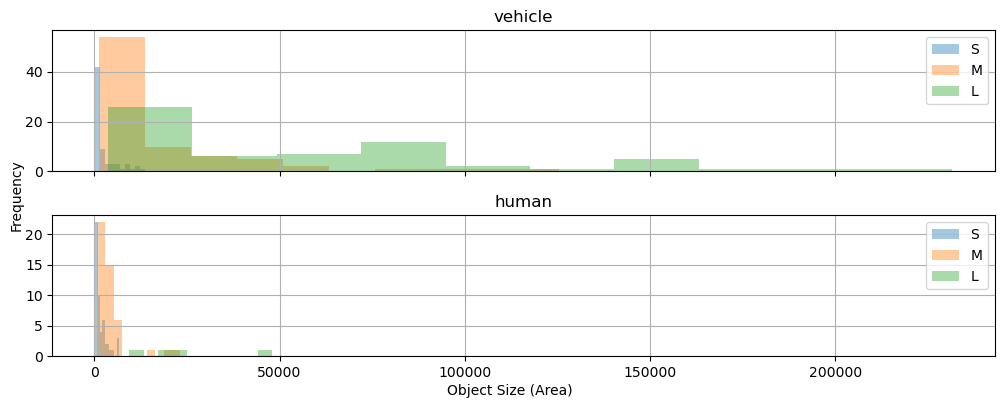

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex='all', figsize=(10, 4))
scale_names = ['S','M','L']

for i, category in enumerate(['vehicle','human']):
    axis = axes[i]    
    for head in range(3):
        data = check_size_df[category][check_size_df[category]['head_num']==head]['area']
        axis.hist(data,alpha=0.4,label=scale_names[head])
    axis.legend()
    axis.set_title(category)
    axis.grid(True)

fig.text(0.5, 0, 'Object Size (Area)', ha='center')
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical')
# Tight layout to prevent overlap
plt.tight_layout()
plt.show()


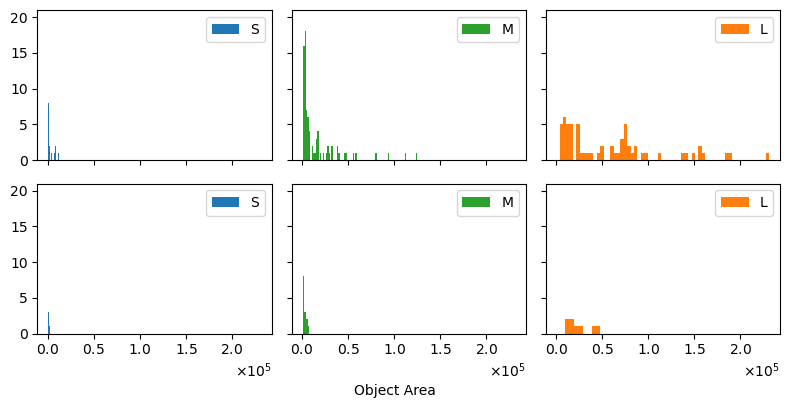

In [19]:
from matplotlib.ticker import ScalarFormatter
fig, axes = plt.subplots(nrows=2, ncols=3, sharex='all', sharey='all', figsize=(8, 4))
scale_names = ['S','M','L']
colors = ['tab:blue','tab:green','tab:orange']

for i, category in enumerate(['vehicle','human']):
    for head in range(3):
        axis = axes[i][head]   

        axis.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axis.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

        axis.set_xticks(range(0,int(2.5e5),int(int(2.5e5)/5)))
        # axis.set_xticklabels(range(0,1e5,20))

        data = check_size_df[category][check_size_df[category]['head_num']==head]['area']
        axis.hist(data,label=scale_names[head],bins=len(data),color=colors[head])
        axis.legend()
        # axis.set_title(category)
        # axis.grid(True)
    
fig.text(0.5, 0, 'Object Area', ha='center')
# fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical')
# Tight layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
[19, 38, 29]
[38, 26, 4]

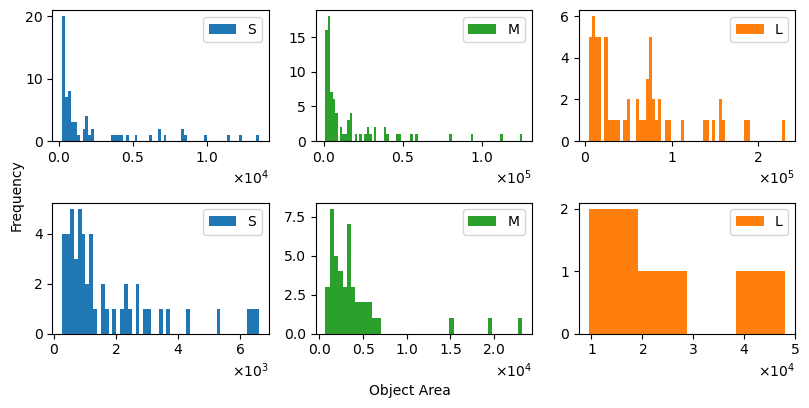

In [78]:
from matplotlib.ticker import ScalarFormatter
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 4))

scale_names = ['S','M','L']
colors = ['tab:blue','tab:green','tab:orange']

for i, category in enumerate(['vehicle','human']):
    for head in range(3):
        axis = axes[i][head] 
        axis.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axis.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

        data = check_size_df[category][check_size_df[category]['head_num']==head]['area']
        axis.hist(data,label=scale_names[head],bins=len(data),color=colors[head])
        axis.legend()
        # axis.set_title(category)
        # axis.grid(True)
    
fig.text(0.5, 0, 'Object Area', ha='center')
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical')
# Tight layout to prevent overlap
plt.tight_layout()
plt.show()

# Instance-Level Similarity Analysis

## Read In Attention Maps

In [29]:
human_attention_path = {
    "vehicle":{
        'DET': '/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/240107 Veh DET',
        'EXP_original':'/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/240107 Veh EXP',
        'EXP_cropped':'/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/240107 Veh EXP/by_head_nocrop',
    },
    "human":{
        'DET': '/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/240107 Hum DET',
        'EXP_original':'/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/240107 Hum EXP',
        'EXP_cropped':'/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/240107 Hum EXP/by_head_nocrop',
    }
}

# Attention Category, Type, Image, pred_idx
human_attention = {
    "vehicle":{
        'DET': defaultdict(defaultdict),
        'EXP_original':defaultdict(defaultdict),
        'EXP_cropped':defaultdict(defaultdict),
    },
    "human":{
        'DET': defaultdict(defaultdict),
        'EXP_original':defaultdict(defaultdict),
        'EXP_cropped':defaultdict(defaultdict),
    }
}

for category, path_by_category in human_attention_path.items():
    head_info_exp = head_info[category][head_info[category]['is_exp_target']]
    for type, path in path_by_category.items():
        # DET
        if type == 'DET':
            path = os.path.join(path,f'instances')
            for file in os.listdir(path):
                if '.mat' not in file: continue
                img_idx = re.findall(r'\d+',file)[0]
                pred_idx = re.findall(r'\d+',file)[1]
                pred_idx = int(pred_idx)
                if str(img_idx) not in included_imgs[category]: continue
                mat = scipy.io.loadmat(os.path.join(path,file))
                human_attention[category][type][img_idx][pred_idx] = mat['output_map_norm']

        # EXP assign target from head to the corresponding pred_idx
        else:
            for head in range(3):
                path_by_head = os.path.join(path,f'head{head}')
                for file in os.listdir(path_by_head):
                    if '.mat' not in file: continue
                    img_idx = re.findall(r'\d+',file)[0]
                    if str(img_idx) not in included_imgs[category]: continue
                    pred_idx = head_info_exp[head_info_exp['img']==int(img_idx)]['pred_idx'].item()
                    pred_idx = int(pred_idx)
                    mat = scipy.io.loadmat(os.path.join(path_by_head,file))
                    human_attention[category][type][img_idx][pred_idx] = mat['output_map_norm']

In [30]:
for category in ['vehicle','human']:
    for type, h in human_attention[category].items():
        print(f"{category}\t{type}\t{len(h)}")
        # for img, i in h.items():
            # print(f"{img}\t{len(i)}")

vehicle	DET	86
vehicle	EXP_original	86
vehicle	EXP_cropped	86
human	DET	68
human	EXP_original	68
human	EXP_cropped	68


In [24]:
xai_saliency_path = {
    "vehicle":'/mnt/h/jinhan/results/bdd/xai_saliency_maps_yolov5s/vehicle_fullgradcamraw_by_head',
    "human":'/mnt/h/jinhan/results/bdd/xai_saliency_maps_yolov5s/human_fullgradcamraw_by_head'
}

#category,type,layer,img,pred_idx
xai_saliency_maps = { 
    "vehicle":{
        'FullGradCAM': {key : defaultdict(defaultdict) for key in range(1,18)},
        'ODAM': {key : defaultdict(defaultdict) for key in range(1,18)},
    },
    "human":{
        'FullGradCAM': {key : defaultdict(defaultdict) for key in range(1,18)},
        'ODAM' : {key : defaultdict(defaultdict) for key in range(1,18)},
    }
}

for category, path in xai_saliency_path.items():
    for dir in os.listdir(path):
        if '.csv' in dir: continue
        layer_num = int(re.findall(r"F\d+",dir)[-1].replace('F',''))

        for file in os.listdir(os.path.join(path,dir)):
            if '.mat' not in file: continue
            if category == 'MSCOCO':
                img_idx = file.replace('-res.png.mat','')
            else:
                img_idx = re.findall(r'\d+-',file)[-1].replace('-','')

            if str(img_idx) not in included_imgs[category]: continue

            head_info_img = head_info[category][head_info[category]['img']==int(img_idx)]
            target_exp = head_info_img[head_info_img['is_exp_target']]

            mat = scipy.io.loadmat(os.path.join(path,dir,file))
            masks_all = mat['masks_all']

            for pred_idx, mask in enumerate(masks_all):

                # Skip empty saliency maps (empty layer due to head chosen)
                if (mask.sum()==1.5 and mask[0,0]==1 and mask[1,1]==0.5) or\
                    not np.any(mask) or\
                    np.all(np.isnan(mask)):
                    continue

                # FullGradCAM with targets grouped by head
                xai_saliency_maps[category]['FullGradCAM'][layer_num][img_idx][pred_idx] = mask

                # Find ODAM by EXP target idx (if from this head)
                if len(target_exp) > 0 and target_exp['pred_idx'].item()==pred_idx:
                    target_exp_idx = target_exp['pred_idx'].item()
                    xai_saliency_maps[category]['ODAM'][layer_num][img_idx][pred_idx] = mask

In [ ]:
for category in ['vehicle','human']:
    for type, h in xai_saliency_maps[category].items():
        print(f"{category}\t{type}\t{len(h)}")
        for layer, l in h.items():
            for img, i in l.items():
                print(f"{img}\t{len(i)}")

## Correlation

In [6]:
matching_xai_type = {
    "DET":"FullGradCAM",
    "EXP_original":"ODAM",
    "EXP_cropped":"ODAM",
}

In [35]:
# category, task, layer, img, pred_idx
PCC_all = {category : {
    task : {
        layer : defaultdict(defaultdict) for layer in range(1,14)
    }
    for task in ['DET','EXP_original','EXP_cropped']
    }
    for category in ['vehicle','human']
} 

RMSE_all = {category : {
    task : {
        layer : defaultdict(defaultdict) for layer in range(1,14)
    }
    for task in ['DET','EXP_original','EXP_cropped']
    }
    for category in ['vehicle','human']
} 

for category in ['vehicle','human']:
    for task in matching_xai_type.keys():
            for img in human_attention[category][task]:
                if img not in included_imgs[category]:continue

                for pred_idx in human_attention[category][task][img]:
                    for layer in range(1,14):
                        # For top 4 layers, images with only S objects have no saliency maps
                        if img not in xai_saliency_maps[category][matching_xai_type[task]][layer]: continue   

                        if pred_idx not in xai_saliency_maps[category][matching_xai_type[task]][layer][img]:
                            print(f"{category} {task} {layer} {img}")
                            continue

                        xai_map = xai_saliency_maps[category][matching_xai_type[task]][layer][img][pred_idx]
                        PCC_all[category][task][layer][img][pred_idx] = np.corrcoef(xai_map.flatten(), human_attention[category][task][img][pred_idx].flatten())[0,1]
                        RMSE_all[category][task][layer][img][pred_idx] = RMSE(xai_map.flatten(), human_attention[category][task][img][pred_idx].flatten())

vehicle DET 9 126
vehicle DET 11 293
vehicle DET 10 610
vehicle DET 12 610


In [38]:
PCC_all['vehicle']['DET'].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

In [ ]:
# pickle.dump(PCC_all, open('/mnt/h/jinhan/xai/results/bdd/yolov5s/bdd_PCC_by_scale.pickle','wb'))
# pickle.dump(RMSE_all, open('/mnt/h/jinhan/xai/results/bdd/yolov5s/bdd_RMSE_by_scale.pickle','wb'))

In [39]:
# category, task, head, layer, img
df = pd.DataFrame(columns=['category','task','layer','img','pred_idx','pcc','rmse'])

for category in ['vehicle','human']:
    for task in matching_xai_type.keys():
            for img in human_attention[category][task]:
                if img not in included_imgs[category]:continue

                for pred_idx in human_attention[category][task][img]:
                    for layer in range(1,14):
                        # For top 4 layers, images with only S objects have no saliency maps
                        if img not in xai_saliency_maps[category][matching_xai_type[task]][layer]: continue   

                        if pred_idx not in xai_saliency_maps[category][matching_xai_type[task]][layer][img]:
                            print(f"{category} {task} {layer} {img}")
                            continue
                                
                        xai_map = xai_saliency_maps[category][matching_xai_type[task]][layer][img][pred_idx]
                        
                        pcc = np.corrcoef(xai_map.flatten(), human_attention[category][task][img][pred_idx].flatten())[0,1]
                        rmse = RMSE(xai_map.flatten(), human_attention[category][task][img][pred_idx].flatten())
                        row = pd.DataFrame([[category,task,layer,img,pred_idx,pcc,rmse]], columns=['category','task','layer','img','pred_idx','pcc','rmse'])
                        df = pd.concat([df, row], ignore_index=True)

vehicle DET 9 126
vehicle DET 11 293
vehicle DET 10 610
vehicle DET 12 610


In [40]:
df.to_csv('/mnt/h/jinhan/xai/results/bdd/yolov5s/bdd_by_instance.csv')

In [4]:
df = pd.read_csv('/mnt/h/jinhan/xai/results/bdd/yolov5s/bdd_by_instance.csv')

In [47]:
check_size_df[category]

,pred_idx,img,x1,y1,x2,y2,head_num,is_exp_target,area
1,0,1048,650,221,660,248,0,False,270
2,1,1048,739,219,758,258,1,True,741
3,0,1084,829,295,871,379,1,True,3528
4,0,1099,879,276,918,365,0,True,3471
5,1,1099,59,278,86,344,1,False,1782
...,...,...,...,...,...,...,...,...,...
132,0,919,866,131,948,342,2,True,17302
133,0,927,893,354,916,419,1,False,1495
134,1,927,854,350,896,414,1,True,2688
135,0,932,180,308,212,386,0,True,2496


In [7]:
F8_df = df[df['layer']==8].reset_index(drop=True)
F8_df['area'] = pd.Series(dtype='int')
F8_df['head_num'] = pd.Series(dtype='int')

In [8]:
# Assign target's bbox size
for row, _ in F8_df.iterrows():
    size_df = check_size_df[F8_df.iloc[row]['category']]
    F8_df.at[row,'area'] = size_df[(size_df['img']==F8_df.iloc[row]['img']) & (size_df['pred_idx']==F8_df.iloc[row]['pred_idx'])]['area'].item()
    F8_df.at[row,'head_num'] = size_df[(size_df['img']==F8_df.iloc[row]['img']) & (size_df['pred_idx']==F8_df.iloc[row]['pred_idx'])]['head_num'].item()

In [91]:
F8_df

,Unnamed: 0,category,task,layer,img,pred_idx,pcc,rmse,area,head_num
0,7,vehicle,DET,8,100,0,0.771273,0.046540,1620.0,1.0
1,20,vehicle,DET,8,1023,0,0.533294,0.061696,16218.0,1.0
2,33,vehicle,DET,8,1031,0,0.482903,0.097050,137424.0,2.0
3,46,vehicle,DET,8,1031,1,0.786068,0.048460,11760.0,1.0
4,59,vehicle,DET,8,1031,2,0.831168,0.041492,23772.0,2.0
...,...,...,...,...,...,...,...,...,...,...
611,7946,human,EXP_cropped,8,99,0,0.351891,0.076168,4416.0,1.0
612,7959,human,EXP_cropped,8,1287,0,0.684022,0.062691,23562.0,2.0
613,7972,human,EXP_cropped,8,1313,0,0.945745,0.028657,9453.0,2.0
614,7985,human,EXP_cropped,8,2252,0,0.725721,0.113099,48077.0,2.0


In [99]:
import seaborn as sns
from scipy.stats import pearsonr

def correlate_and_plot(df,x_column,y_column,title):
    # Calculate the correlation coefficient and p-value
    correlation_coefficient, p_value = pearsonr(df[x_column], df[y_column])

    # Create the scatter plot with regression line
    plt.figure(figsize=(10, 6))
    sns.regplot(x=x_column, y=y_column, data=df, ci=None, line_kws={"color": "red"})

    # Annotate the plot with correlation coefficient and p-value
    plt.annotate(f'Correlation coefficient: {correlation_coefficient:.2f}\nP-value: {p_value:.2g}',
                xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
    plt.xlim(0,200000)

    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.title(title)

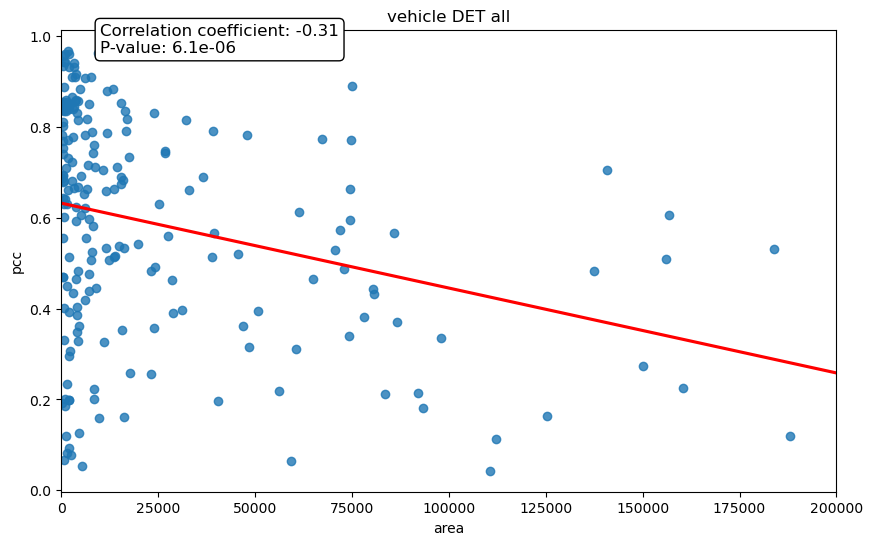

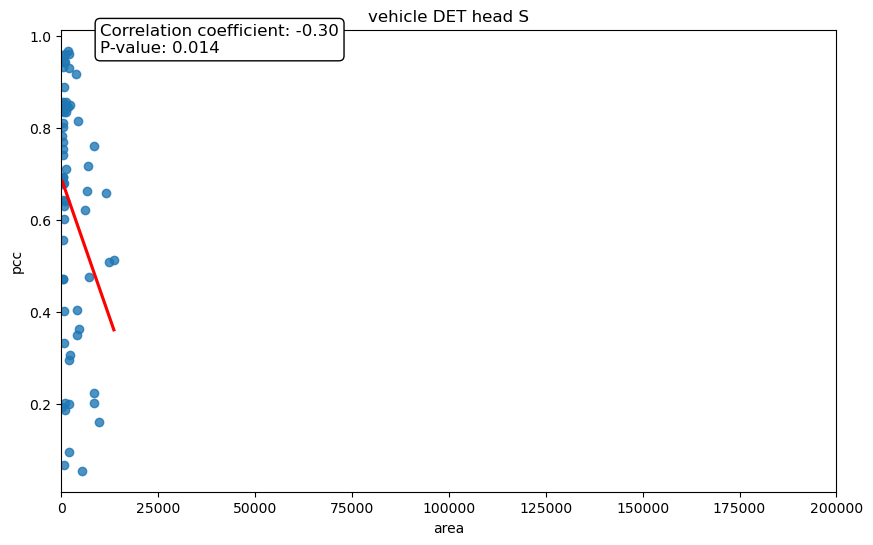

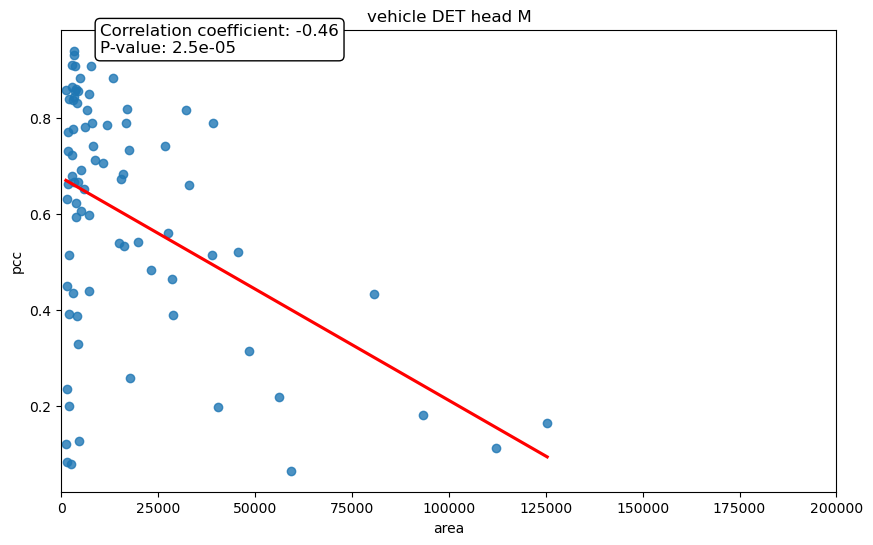

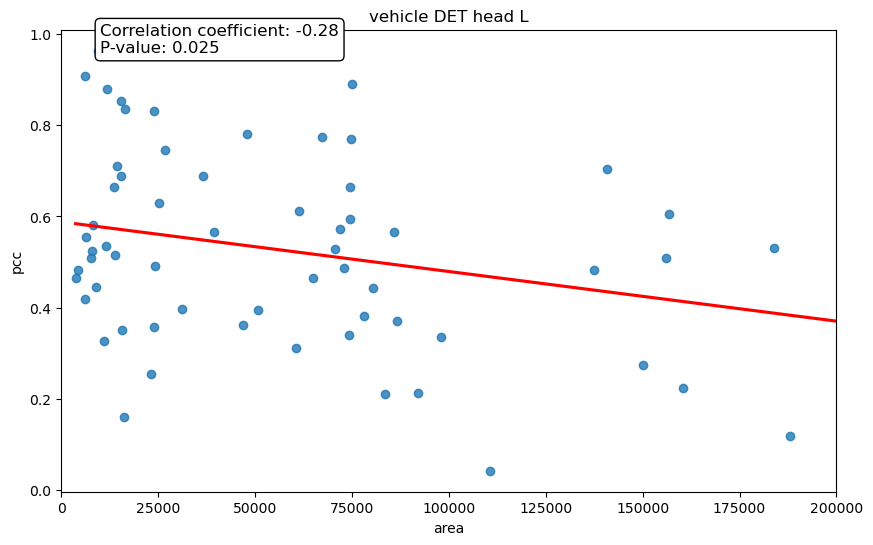

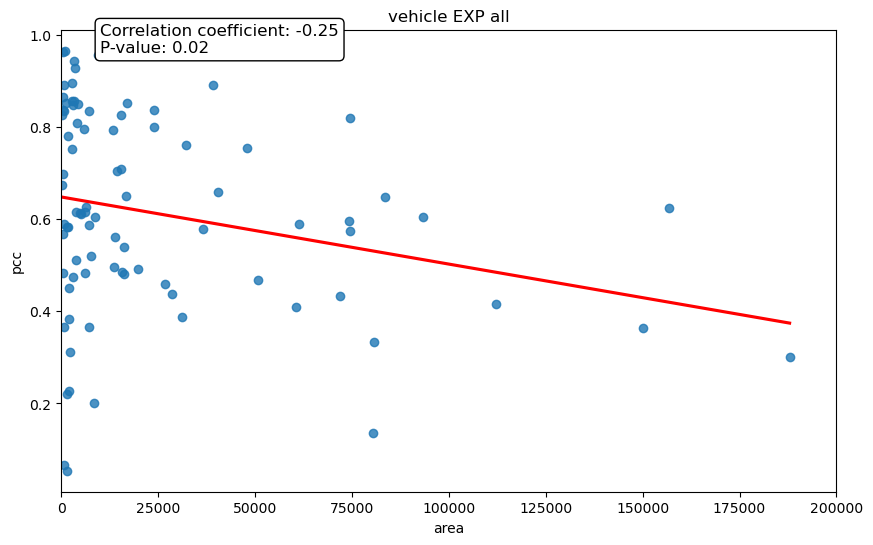

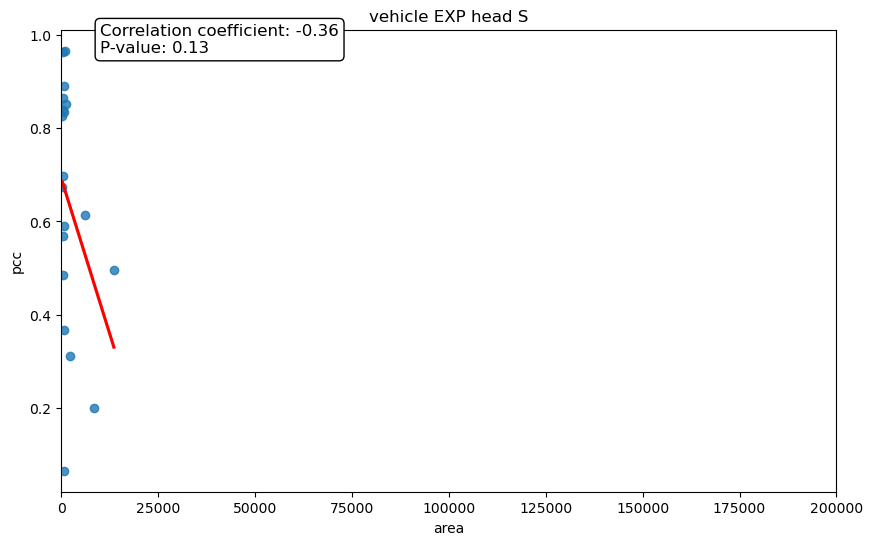

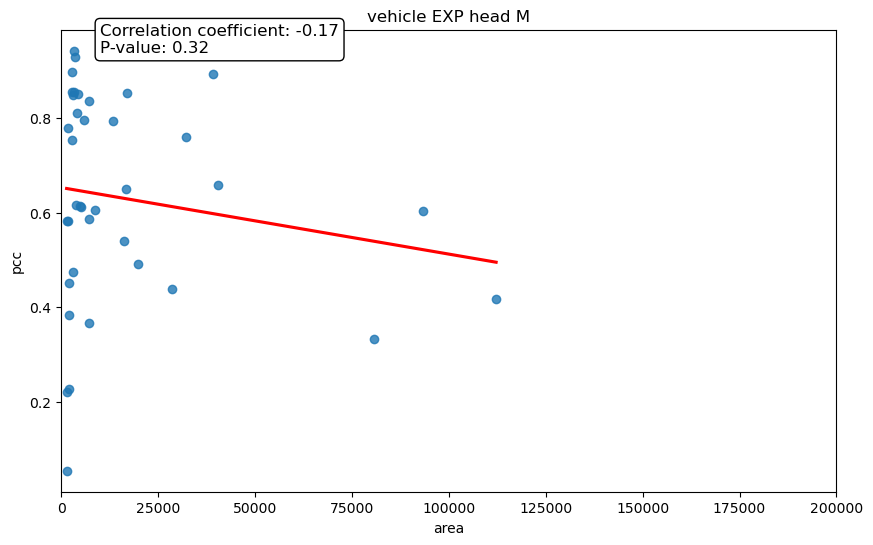

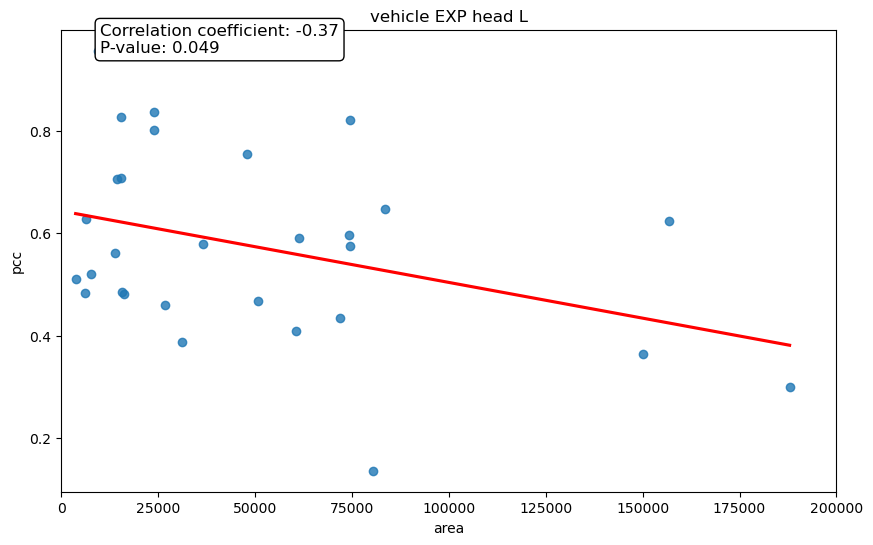

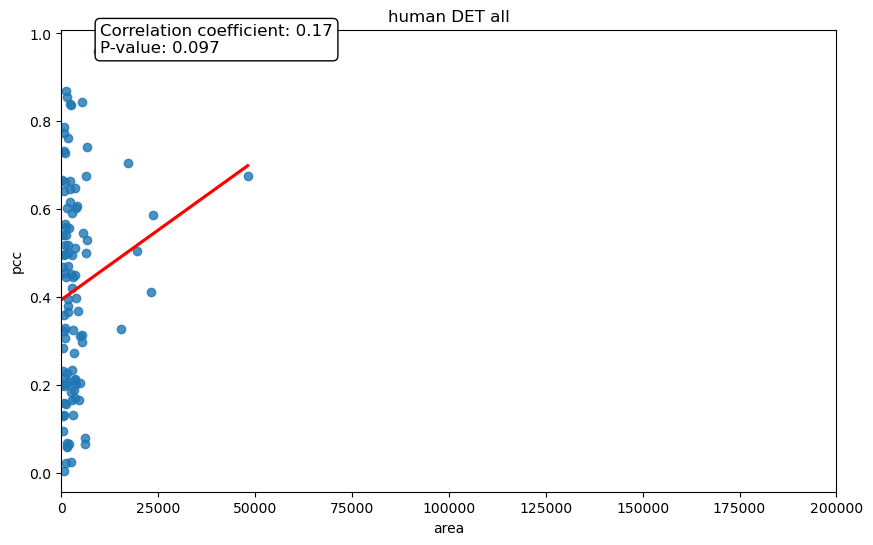

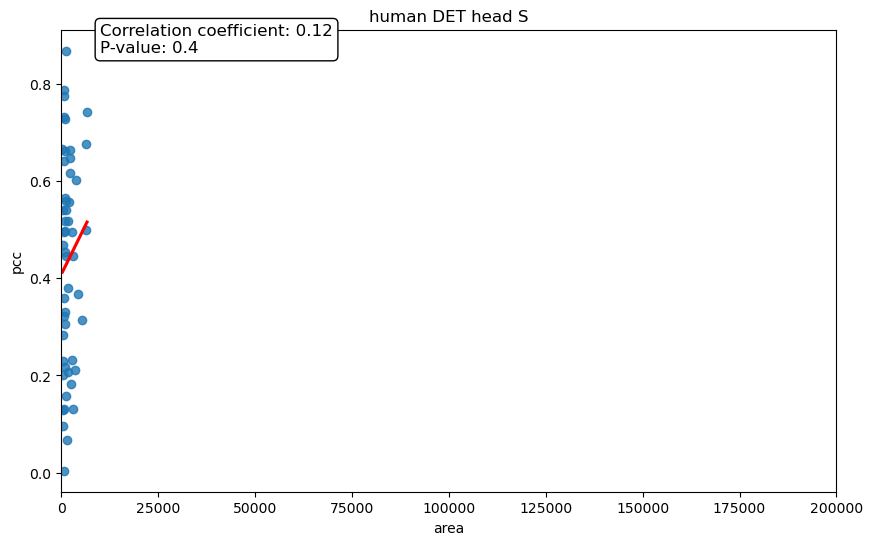

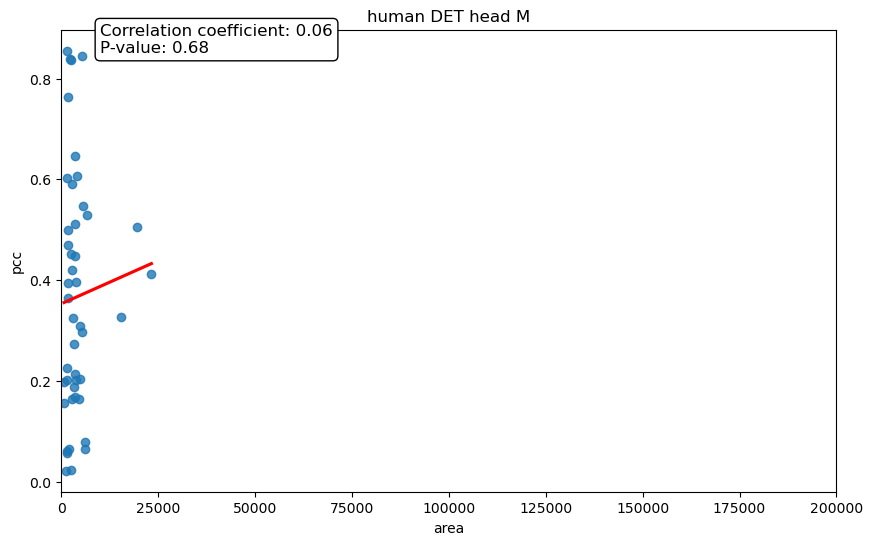

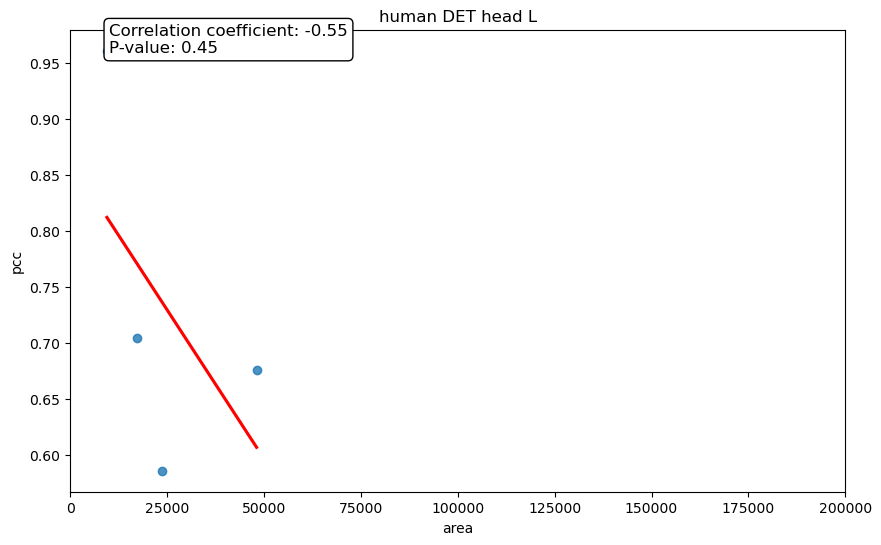

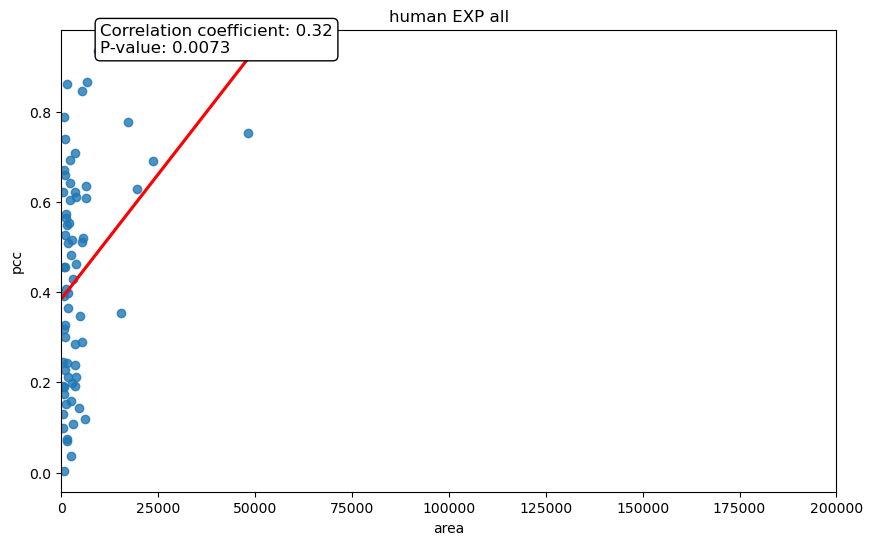

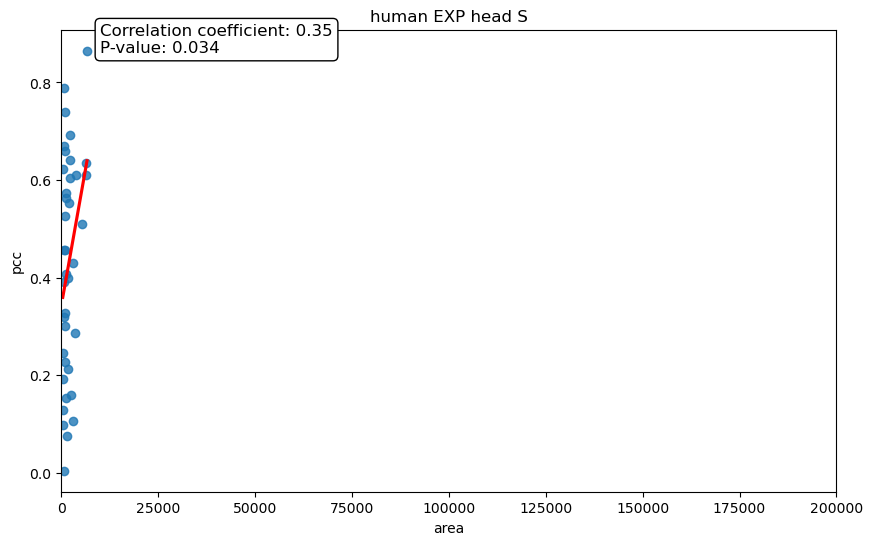

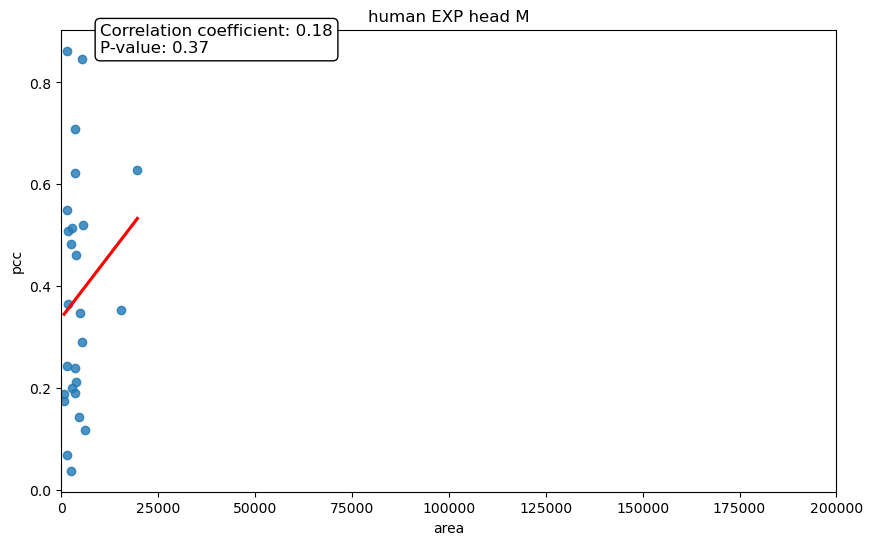

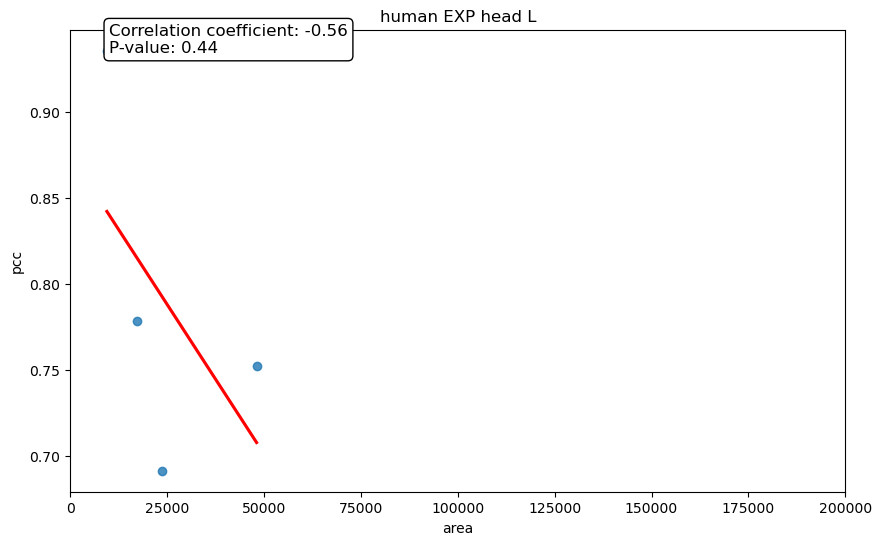

In [100]:
head_names = ['S','M','L']

for category in ['vehicle','human']:
    for task in ['DET','EXP_original']:
        focused_df = F8_df[(F8_df['category']==category) & (F8_df['task']==task)]

        correlate_and_plot(focused_df, 'area','pcc',f"{category} {task.replace('_original','')} all")

        for head_num in range(3):
            focused_df = F8_df[(F8_df['category']==category) & (F8_df['task']==task) & (F8_df['head_num']==head_num)]
            correlate_and_plot(focused_df, 'area','pcc',f"{category} {task.replace('_original','')} head {head_names[head_num]}")

        # plt.figure()
        # inds = focus_df['area'].to_numpy().argsort()
        # areas = focus_df['area'].to_numpy()[inds]
        # pccs = focus_df['pcc'].to_numpy()[inds]
        # plt.plot(areas,pccs)
        # plt.scatter(focus_df['area'].values,focus_df['pcc'].values)
        # plt.title(f"{category} {task}")
        # plt.show()

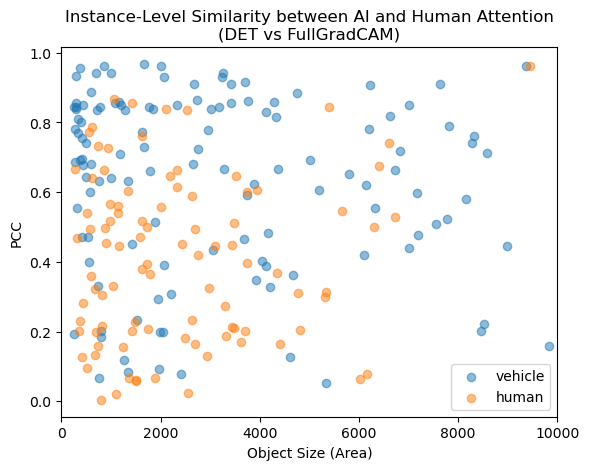

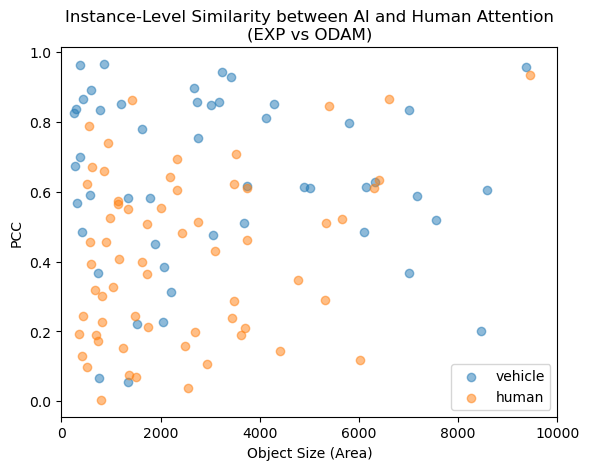

In [23]:
head_names = ['S','M','L']

for task in ['DET','EXP_original']:
    plt.figure()
    for category in ['vehicle','human']:

        focused_df = F8_df[(F8_df['category']==category) & (F8_df['task']==task)]

        plt.scatter(focused_df['area'].values, focused_df['pcc'].values, c=('tab:blue' if category=='vehicle' else 'tab:orange'),alpha=0.5,label=category)

        plt.xlim(0,10000)
    if task == 'DET':
        plt.title('Instance-Level Similarity between AI and Human Attention\n(DET vs FullGradCAM)')
    else:
        plt.title('Instance-Level Similarity between AI and Human Attention\n(EXP vs ODAM)')
    plt.ylabel('PCC')
    plt.xlabel('Object Size (Area)')
    plt.legend()
    plt.show()

        # correlate_and_plot(focused_df, 'area','pcc',f"{category} {task.replace('_original','')} all")

        # for head_num in range(3):
        #     focused_df = F8_df[(F8_df['category']==category) & (F8_df['task']==task) & (F8_df['head_num']==head_num)]
        #     correlate_and_plot(focused_df, 'area','pcc',f"{category} {task.replace('_original','')} head {head_names[head_num]}")

        # plt.figure()
        # inds = focus_df['area'].to_numpy().argsort()
        # areas = focus_df['area'].to_numpy()[inds]
        # pccs = focus_df['pcc'].to_numpy()[inds]
        # plt.plot(areas,pccs)
        # plt.scatter(focus_df['area'].values,focus_df['pcc'].values)
        # plt.title(f"{category} {task}")
        # plt.show()